# BOAR with SIMsalabim Organic Photovoltaic (OPV) example
Version 1.0.0
(c) Vincent M. Le Corre, Larry Lueer, i-MEET 2021-2023

This notebook is made to use BOAR in combination with drift-diffusion modeling to fit of 'fake' JV curves.    
To perform the drift-diffusion simulation in the background we use the open-source program [SIMsalabim](https://github.com/kostergroup/SIMsalabim), for more information about SIMsalabim please check the [GitHub repository](https://github.com/kostergroup/SIMsalabim)    
Make sure you have SIMsalabim installed before running this Notebook.   

Here we are fitting an typical OPV cell with the following structure:  
ITO|ZnO|PM6-L8BO-PCBM|MoOx|Ag

In [1]:
# Activate matplotlib widgets
# %matplotlib inline
# comment the next line if you are on the jupyterhub server
# %matplotlib widget 
# %matplotlib notebook

# Import libraries
import sys,os
from sklearn.preprocessing import minmax_scale
import warnings
warnings.filterwarnings('ignore') # comment this out to see warnings

# Import boar package
sys.path.append(os.path.abspath('../')) # add directory containing boar package to path
from boar import *


### Import Experimental Data
In this section you need to write a function that imports the experimental data. The function should return two array X and y. X is a 2D array with the experimental data. Each row of X is a data point. y is a 1D array with the experimental results. Each row of y is a result vector for the corresponding data point in X.  
For example, if you are trying to fit light-intensity dependent JV curves, then X is a 2D array (or list) with in the first column the applied voltage ('Vext') and in the second column the light intensity ('Gfrac') and y is a 1D array (or list) with the JV curves. If you have several light intensities, just append the data to X and y.  

```python
      Vext   Gfrac             Jext  
     _            _          _        _   
X = |  0   |   0   |   y =  |  J(0,0)  |  
    | 0.1  |   0   |        | J(0.1,1) |  
    |  .   |   .   |        |   .      | 
    |  .   |   .   |        |   .      | 
    |  .   |   .   |        |   .      | 
    |  .   |   .   |        |   .      | 
    |  1   |   0   |        | J(1,0)   |  
    |  0   |   1   |        | J(0,1)   |  
    | 0.1  |   1   |        | J(0.1,1) |  
    |  .   |   .   |        |   .      | 
    |  .   |   .   |        |   .      | 
    |  .   |   .   |        |   .      | 
    |_ 1   |   1  _|        |_ J(1,1) _|  
      
```

In [2]:
# Define the path to the data and to the SIMsalabim directory
curr_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(curr_dir, '..')) # path to the parent directory
path2simu = os.path.join(parent_dir, 'SIMsalabim','SimSS') # path to the SIMsalabim directory
# Directory where the results are stored
res_dir = os.path.join(curr_dir,'temp') # absolute path to the results directory (note that this will be delete in the last cell of this notebook)
dev_par_file = os.path.join(parent_dir,'Example_Data','Chao','device_parameters_chao.txt') # absolute path to the device parameter file 
path2JV = os.path.join(parent_dir,'Example_Data','Chao') # absolute path to the JV file

# Define the fixed parameters and the light intensities
X_dimensions = ['Vext','Gfrac']
suns = [0.1,0.5,1]

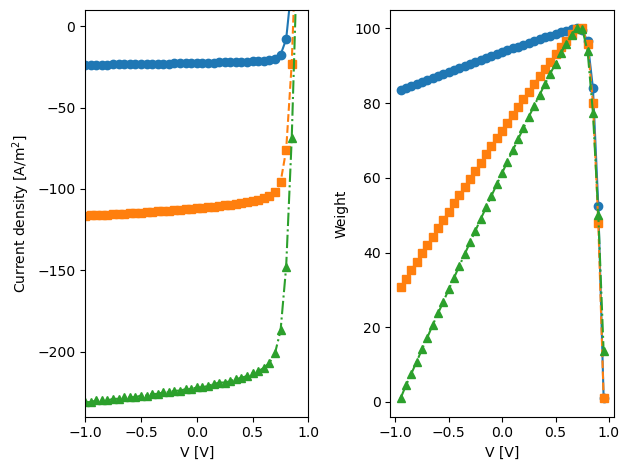

In [3]:
# Example function to import JV data
def get_JV_exp(suns,path2JV='',Vlim=[],plot=True):
    """ Example function to import JV data from csv files

    Parameters
    ----------
    suns : list of floats
        List of light intensities
    path2JV : str, optional
        Path to the JV data, by default ''
    Vlim : list, optional
        Voltage limits, by default []
    plot : bool, optional
        Plot the JV curves, by default True

    Returns
    -------
    Xs : list of lists
        List of lists of the voltage and light intensity
    ys : list of floats
        List of the current densities
    weights_ : list of floats
        List of the weights
    """    
    Xs,ys = [],[]
    weights_ = []
    markers = ['o','s','^','v']
    # markers = [None,None,None,None]
    lines = ["-","--","-.",":"]
    
    JvExp_filename = []
    for i in suns:
        if i == 'dark':
            JvExp_filename.append(os.path.join(path2JV,'1#-pin5_O-ZnO-PM6-L8BO-C70_dark-fresh.csv'))
        else:
            JvExp_filename.append(os.path.join(path2JV,'1#-pin5_O-ZnO-PM6-L8BO-C70_'+str(i)+' sun-fresh.csv'))
    


    Gfracs = suns
    
    err,V,J,Gfrac = [],[],[],[]
    X,y = [],[]
    
    weights = []
    idx = 0
    for i,G in zip(JvExp_filename,Gfracs):
        power,Vs = [],[]
        data2fit = pd.read_csv(filepath_or_buffer=os.path.join(i),names=['V','J'], sep=",")
        # data2fit.dropna(how="all", inplace=True) # drop the empty line at file-end
        if Vlim == []:
            Vmin = min(data2fit['V'])
            Vmax = max(data2fit['V'])
        else:
            Vmin = Vlim[0]
            Vmax = Vlim[1]
        if plot:
            plt.subplot(1, 2, 1)
            plt.plot(data2fit['V'],data2fit['J'],label='Gfrac = '+str(G),marker=markers[idx],color='C'+str(idx),linestyle=lines[idx])
            plt.xlim([-1,1])
            plt.ylim([-240,10])
            plt.xlabel('V [V]')
            plt.ylabel('Current density [A/m$^2$]')
        for index, row in data2fit.iterrows():
            if row['V'] > Vmin and row['V'] < Vmax:
                if G=='dark':
                    G=0
                Vs.append(row['V'])
                X.append([row['V'],G])
                y.append(row['J'])
                if G == 0:
                    power.append(1)
                else:
                    power.append(-row['V']*row['J'])
        
        V=data2fit['V']
        if G > 0:
            power = minmax_scale(np.asarray(power), feature_range=(1, 100))
        else:
            power = np.ones(len(power))
        weights = weights + list(power)
        if plot:
            plt.subplot(1, 2, 2)
            plt.plot(Vs,power,label='Gfrac = '+str(G),marker=markers[idx],color='C'+str(idx),linestyle=lines[idx])
            plt.xlabel('V [V]')
            plt.ylabel('Weight')

        
        idx += 1
    X = np.asarray(X)
    y = np.asarray(y)
    V = np.asarray(V)
    weights = np.asarray(weights)

    if plot:
        plt.tight_layout()
        plt.show()
    return X,y,weights

Xs,ys,weights_ = get_JV_exp(suns,Vlim=[-1,1],plot=True,path2JV=path2JV)


### Fit non-ideal diode model
In this section you need to write a function that fits the non-ideal diode model to dark-JV curves. We do this to get the series resistance ('Rseries') and shunt resistance ('Rshunt') from the dark-JV curves to avoid fitting them in the multi-objective optimization. 

Note: Running this cell is not necessary, run it only if you want to see the results.

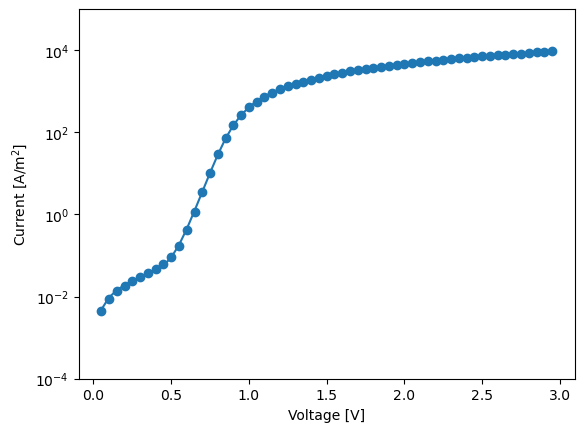

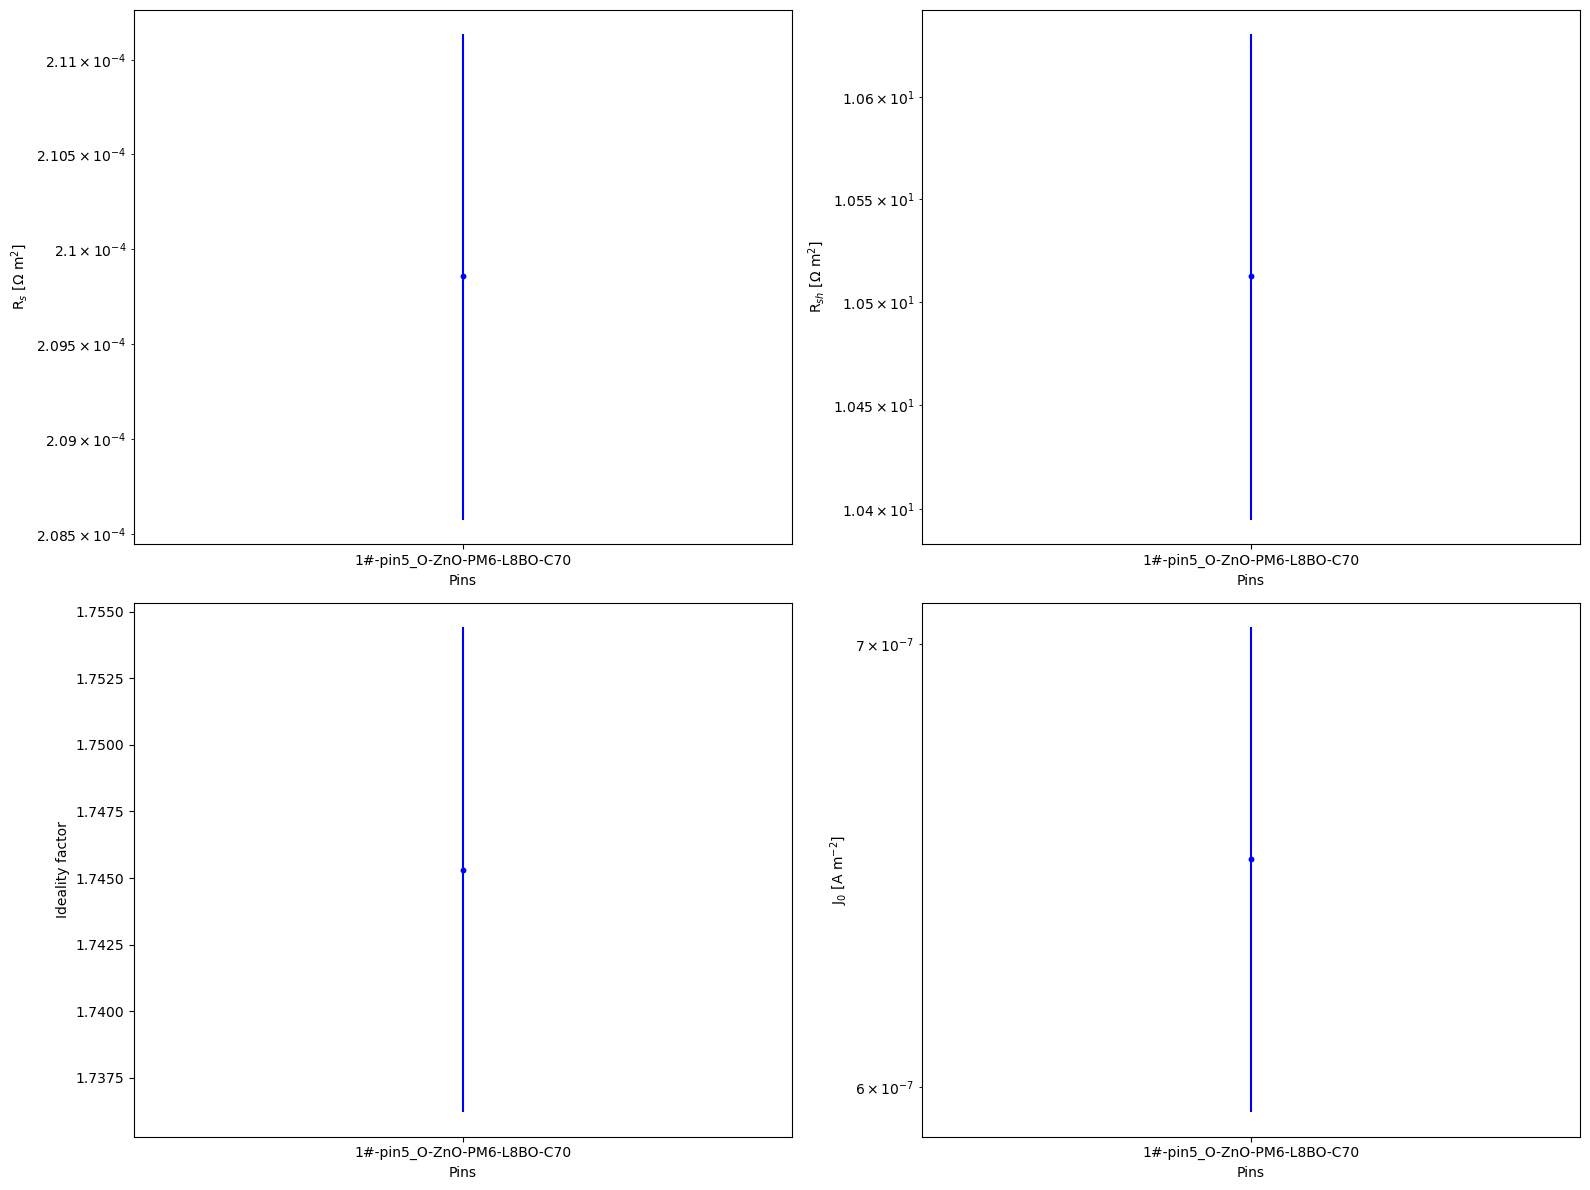

In [4]:
# Import  and fit diode equation to dark JV data
fit_dark = True
if fit_dark:

    X,y,weights = get_JV_exp(['dark'],Vlim = [0,3],plot=False,path2JV=path2JV) # import dark JV data
    pins = ['1#-pin5_O-ZnO-PM6-L8BO-C70']
    markers = ['o','s','^','v']
    Rs, Rsh, J0, n, errRs, errRsh, errJ0, errn = [],[],[],[],[],[],[],[]
    idx = 0 
    dio = Non_Ideal_Diode_agent()

    V = X[:,0]
    J = y
    # Fit the non ideal diode equation
    res = dio.FitNonIdealDiode(V,J,T=300,JV_type='dark',take_log=True,bounds=([1e-20, 0.8, 1e-8, 1e-3], [1e-3, 3, 1e2, 1e8]),p_start={'J0':1e-6})
    Rs.append(res['Rs'])
    Rsh.append(res['Rsh'])
    J0.append(res['J0'])
    n.append(res['n'])
    errRs.append(res['Rs_err'])
    errRsh.append(res['Rsh_err'])
    errJ0.append(res['J0_err'])
    errn.append(res['n_err'])
    
    plt.figure(2)
    plt.plot(V,abs(J),'o',c='C'+str(idx))
    plt.semilogy(V,abs(dio.NonIdealDiode_dark(V,res['J0'],res['n'],res['Rs'],res['Rsh'])),c='C'+str(idx))
    idx += 1

    plt.xlabel('Voltage [V]')
    plt.ylabel('Current [A/m$^2$]')
    plt.ylim(1e-4,1e5)
    plt.show()

    fig, axs = plt.subplots(2, 2, figsize=(16,12))
    axs[0, 0].errorbar(pins, Rs, yerr=errRs, fmt='b.')
    axs[0, 0].semilogy(pins, Rs, 'b.', label='Rs')
    axs[0, 0].set_xlabel('Pins')
    axs[0, 0].set_ylabel('R$_s$ [$\Omega$ m$^2$]')

    axs[0, 1].errorbar(pins, Rsh, yerr=errRsh, fmt='b.')
    axs[0, 1].semilogy(pins, Rsh, 'b.', label='Rsh')
    axs[0, 1].set_xlabel('Pins')
    axs[0, 1].set_ylabel('R$_{sh}$ [$\Omega$ m$^2$]')

    axs[1, 0].errorbar(pins, n, yerr=errn, fmt='b.')
    axs[1, 0].plot(pins, n, 'b.', label='n')
    axs[1, 0].set_xlabel('Pins')
    axs[1, 0].set_ylabel('Ideality factor')

    axs[1, 1].errorbar(pins, J0, yerr=errJ0, fmt='b.')
    axs[1, 1].semilogy(pins, J0, 'b.', label='J0')
    axs[1, 1].set_xlabel('Pins')
    axs[1, 1].set_ylabel('J$_0$ [A m$^{-2}$]')

    plt.tight_layout()
    plt.show()

### Multi-Objective Optimization
Below we will perform the Bayesian optimization to fit the experimental data.

#### Define the fitting parameters

In [5]:
# define Fitparameters
Start_values = {'kdirect':5e-18,'mun_0':2e-8,'mup_0':8e-8,'Nc':5e26,'Gehp':1.28e28,'Bulk_tr':1e20,'Gehp':1.28e28}
params = []
Bulk_tr = Fitparam(name = 'Bulk_tr', val = Start_values['Bulk_tr'] , relRange = 0.2, lims=[1e17,5e22],range_type='log',optim_type='log',lim_type='absolute',display_name='N$_{Tr}$',unit='m$^{-3}$')
params.append(Bulk_tr)

kdirect = Fitparam(name = 'kdirect', val = Start_values['kdirect'] , relRange = 0.2, lims=[1e-19,1e-15],range_type='log',optim_type='log',lim_type='absolute',display_name='k$_{2}$',unit='m$^{3}$ s$^{-1}$')
params.append(kdirect)

mun_0 = Fitparam(name = 'mun_0', val = Start_values['mun_0'] , relRange = 0.2, lims=[1e-8,1e-6],range_type='log',optim_type='log',lim_type='absolute',display_name='$\mu_n$',unit='m$^{2}$ V$^{-1}$ s$^{-1}$')
params.append(mun_0)

mup_0 = Fitparam(name = 'mup_0', val = Start_values['mup_0'] , relRange = 1.5, lims=[1e-8,1e-6],range_type='log',optim_type='log',lim_type='absolute',display_name='$\mu_p$',unit='m$^{2}$ V$^{-1}$ s$^{-1}$')
params.append(mup_0)

# If you want to also fit the series and shunt resistance, uncomment the following lines
# Rseries = Fitparam(name = 'Rseries', val = 1e-4, relRange = 1, lims=[1e-5,1e-1],range_type='log',optim_type='log',lim_type='absolute',display_name='R$_{s}$',unit='$\Omega$ m$^2$)
# params.append(Rseries)

# Rshunt = Fitparam(name = 'Rshunt', val = 3e2 , relRange = 1, lims=[1e0,1e3],range_type='log',optim_type='log',lim_type='absolute',display_name='R$_{sh}$',unit='$\Omega$ m$^2$)
# params.append(Rshunt)

W_R = Fitparam(name = 'W_R', val = 0 , relRange = 1, lims=[-0.5,0],range_type='linear',optim_type='linear',lim_type='absolute',display_name='W$_R$',unit='eV')
params.append(W_R)

W_L = Fitparam(name = 'W_L', val = 0 , relRange = 0, lims=[0,0.5],range_type='linear',optim_type='linear',lim_type='absolute',display_name='W$_L$',unit='eV')
params.append(W_L)

CB_LTL = Fitparam(name = 'CB_LTL', val = 0 , relRange = 1, lims=[0,0.4],range_type='linear',optim_type='linear',lim_type='absolute',display_name='CB$_{ETL}$',unit='eV')
params.append(CB_LTL)

Gehp = Fitparam(name = 'Gehp', val = Start_values['Gehp'] , relRange = 0.2, lims=[1.1e28,2e28],range_type='log',optim_type='linear',axis_type='log',lim_type='absolute',display_name='G$_{ehp}$',unit='m$^{-3}$ s$^{-1}$')
params.append(Gehp)

params_true = copy.deepcopy(params)


### Start the optimization

In [6]:
## Here we first perform a fit with the nonideal diode model to extract the series and shunt resistance so that we can use and do not have to fit them again, this is not necessary but will speed up the fit. 
# Get dark JV and fit nonIdeal diode model
use_diode_fit = True
if use_diode_fit:
    X,y,weights = get_JV_exp(['dark'],Vlim = [0,3],plot=False,path2JV = path2JV)
    V = X[:,0]
    J = y
    # Fit the non ideal diode equation to get the series and shunt resistance
    dio = Non_Ideal_Diode_agent() # initialize the diode agent
    res = dio.FitNonIdealDiode(V,J,T=300,JV_type='dark',take_log=True,bounds=([1e-20, 0.8, 1e-8, 1e-3], [1e-3, 3, 1e2, 1e8]),p_start={'J0':1e-6})
    Rseries = res['Rs']
    Rshunt= res['Rsh']

    fixed_str = '-Rseries {:.5e} -Rshunt {:.5e} '.format(Rseries,Rshunt) # string to be added to the command line
else:
    fixed_str = ''


Scaling runs for target 0:   0%|          | 0/1 [00:00<?, ?it/s]

Starting with initial points


Initial points:   0%|          | 0/4 [00:00<?, ?it/s]

Initial points done in 32.80 s
Starting with BO


BO runs:   0%|          | 0/20 [00:00<?, ?it/s]

BO done in 211.21 s
Ground truth minimum at: [17.67841337886885, -17.609204756486587, -6.302423246698634, -7.030237904278885, -2.4629062657702865, 0.0, 2.0] with function value: 0.01649108791286135
Minimum of surrogate function: [20.76211821401955, -15.384532881147747, -6.0, -6.0, -2.069900353368186, 0.8773487389091323, 2.0] with function value -1.3318090534413694


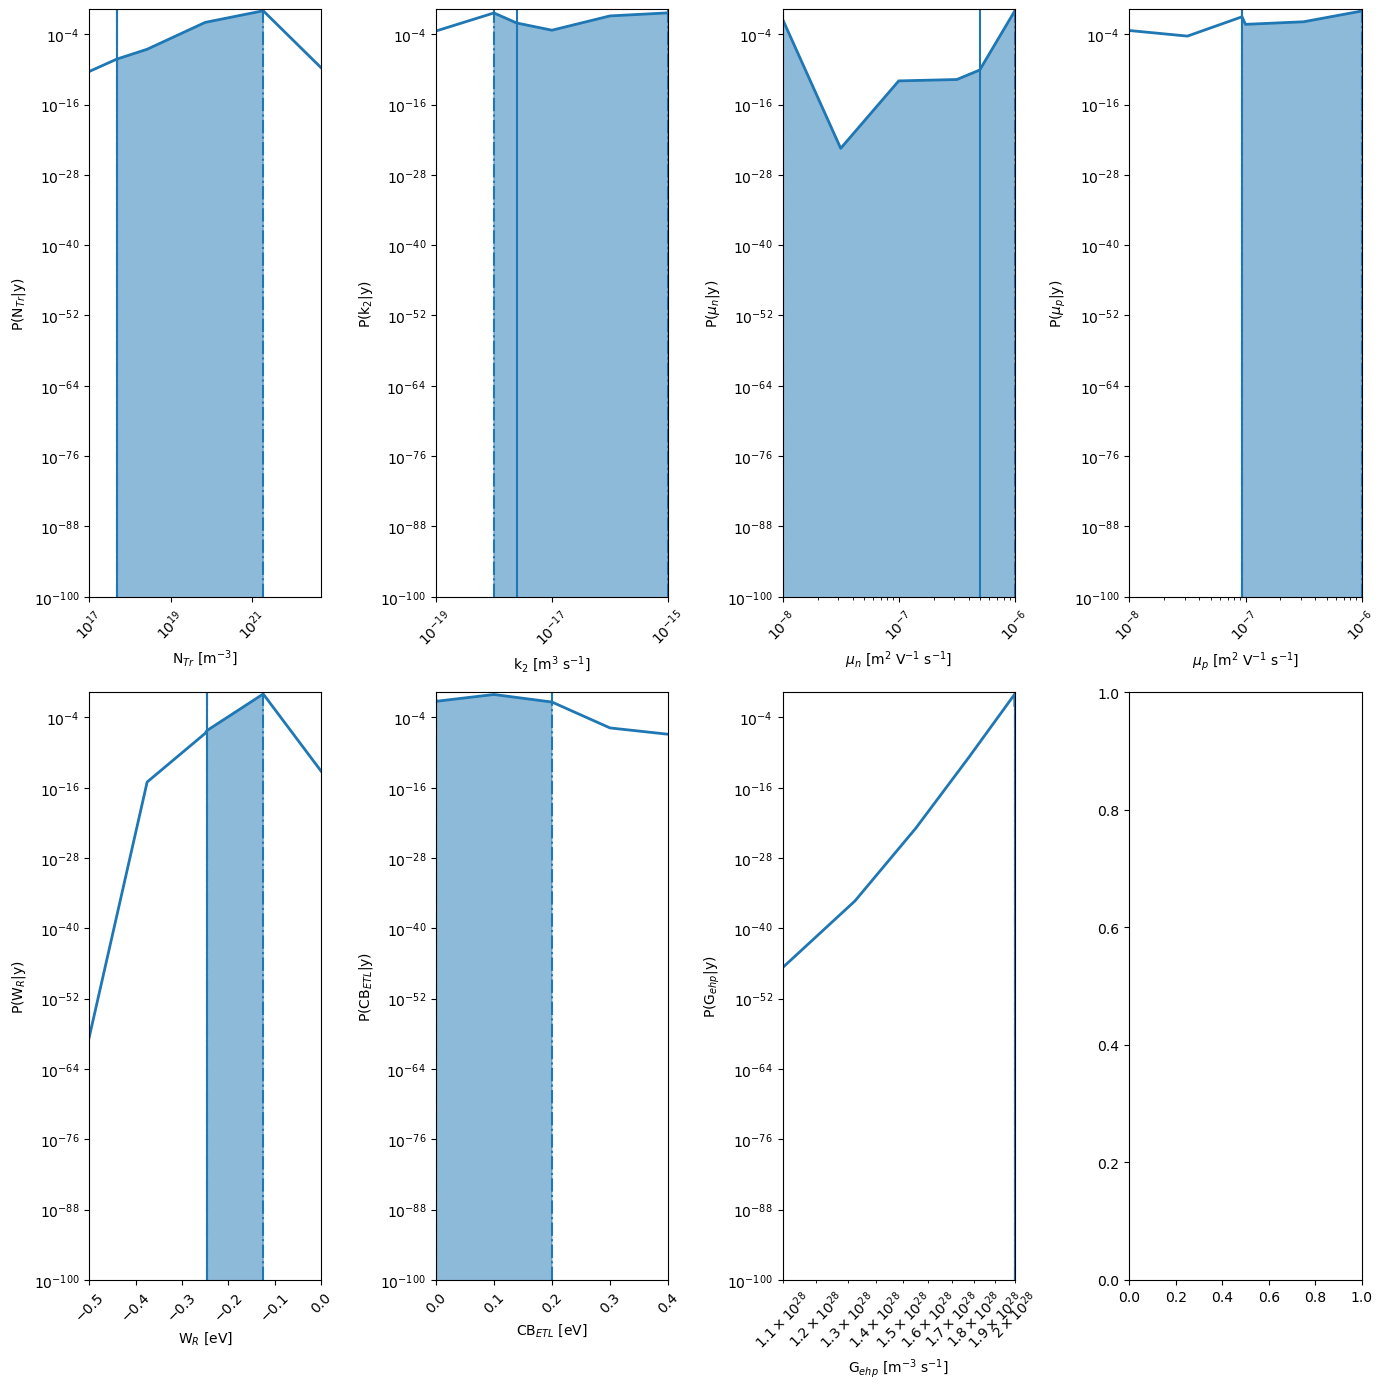

In [7]:
# Do the fit
# Get experimental data light JV
X,y,weights = get_JV_exp(suns,path2JV=path2JV,Vlim=[-0.2,1.0],plot=False)
X_dimensions = ['Vext','Gfrac']
fixed_str = fixed_str + f'-Vmin {-0.25} -Vmax {1.25} '
# Define weighting for the different JV curves
use_weighting = True
if use_weighting:
    weight = weights
else:
    weight = 1

# initialize the simulation agent
dda = Drift_diffusion_agent(path2simu=path2simu) 

# Define the target
target = {'model':partial(dda.DriftDiffusion_relative,X_dimensions=X_dimensions,max_jobs=3,fixed_str=fixed_str,dev_par_fname=dev_par_file),'target_name':'JV','data':{'X':X,'y':y,
            'X_dimensions':['Vext','Gfrac'],'X_units':['V','sun'],'y_dimension':'Current density','y_unit':r'$A m^{-2}$'}
            ,'params':copy.deepcopy(params), 'weight':weight,'target_weight':1}

# Define optimizer
mo = MultiObjectiveOptimizer(res_dir=res_dir,params=params,targets=[target]) # initialize the optimizer
mo.warmstart = 'none' # 'recall' data from Path2OldXY file

# Define the number of iterations for the optimization
n_jobs = 4
n_jobs_init = 20
n_yscale=20
n_initial_points = 80
n_BO = 80
n_BO_warmstart = 80

kwargs = {'check_improvement':'relax','max_loop_no_improvement':15,'xtol':1e-3,'ftol':1e-3}
kwargs_posterior = {'Nres':5,'Ninteg':1e5,'logscale':True,'vmin':1e-100,'zoom':0,'min_prob':1e-40,'clear_axis':True,'show_points':True,'savefig':True,'figname':'param_posterior' ,'show_fig':True,'figsize':(14,14)}
kwargs_plot_obj = {'zscale':'linear','show_fig':False}

r = mo.optimize_sko_parallel(n_jobs=n_jobs,n_yscale=n_yscale, n_BO=n_BO, n_initial_points = n_initial_points,n_BO_warmstart=n_BO_warmstart,n_jobs_init=n_jobs_init,kwargs=kwargs,verbose=False,loss='linear',threshold=100,base_estimator = 'GP',show_objective_func=False,show_posterior=True,kwargs_posterior = kwargs_posterior,kwargs_plot_obj=kwargs_plot_obj)
# pf.append(deepcopy(target['params'])) # collects optimized fitparameters
rrr = r['r'] # the results dict of the last optimizer.tell()

best_params = copy.deepcopy(mo.params) # get the best parameters

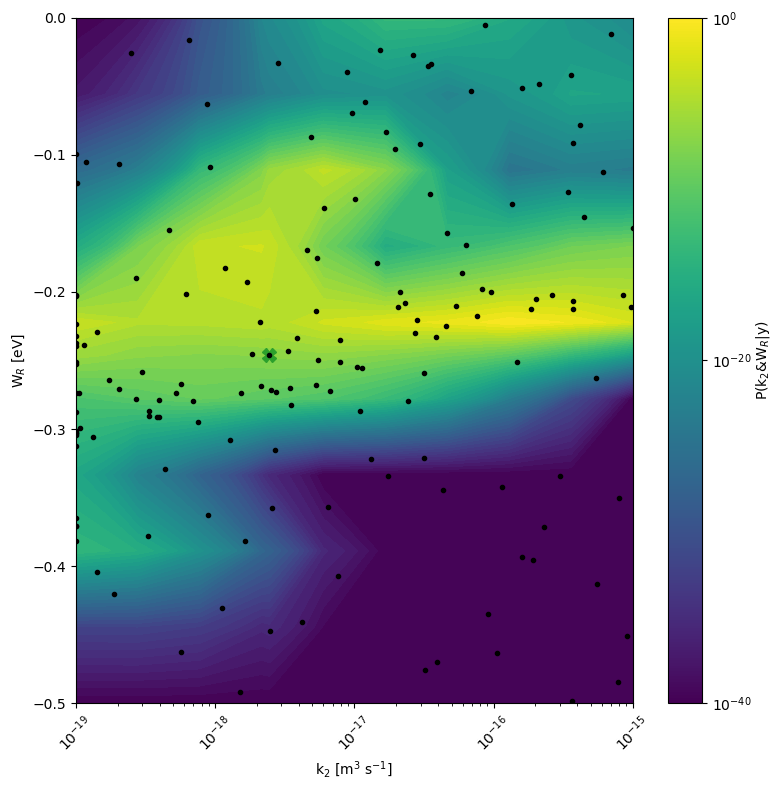

In [8]:
# plot the 2D posterior
mo.marginal_posterior_2D('kdirect','W_R',points=mo.points,logscale=True,Nres=10,Ninteg=1e5,vmin=1e-40)

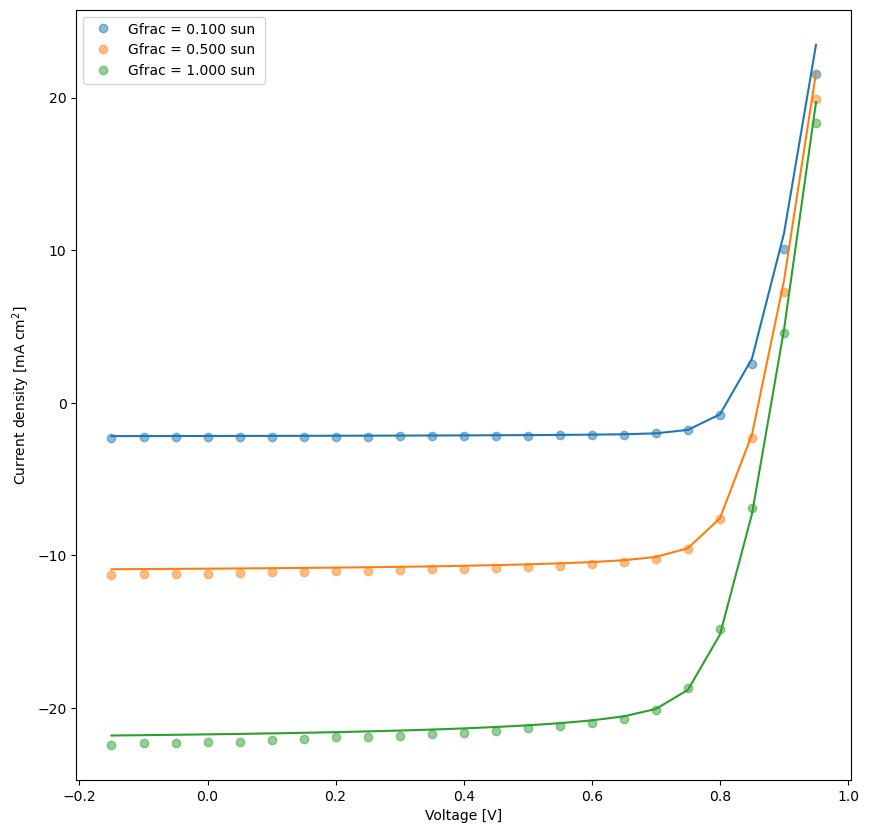

In [9]:
# plot the fit results
fit_results = []
kwargs_plot_res = {'x_scaling':1,'xaxis_label':'Voltage [V]','xscale_type':'linear','y_scaling':1/10,'yaxis_label':'Current density [mA cm$^2$]','yscale_type':'linear','norm_data':False,'delog':False,'figsize':(10,10),'savefig':False,'figname':'JV_fits','figdir':'temp'}

for num,t in enumerate(mo.targets):
    kwargs_plot_res['figname'] = os.path.join(res_dir,t['target_name']+f'_fit_{num}')
    dda.plot_fit_res(t,mo.params,'Vext',xlim=[],ylim=[],kwargs=kwargs_plot_res)

    X = t['data']['X']
    y = t['data']['y']
    X_dimensions = t['data']['X_dimensions']
    yfit = t['model'](X,mo.params,X_dimensions=X_dimensions) # get the best fits

    data = np.concatenate((X, y.reshape(len(y),1), yfit.reshape(len(yfit),1)), axis=1)
    fit_results.append(data)

# prepare the data for saving
param_dict = dda.get_param_dict(mo.params) # get fitparameters (and fixed ones) as dict
pout = [[f'{v:.3E}' if isinstance(v,float) else v for _,v in pp.items()] for pp in param_dict] # convert to list of lists


# produce output excel file with data, fitparameters and FOMs
fn_xlsx = 'fits_results.xlsx'
namecols = X_dimensions + ['Jexp','Jfit']
# delete old file if it exists
if os.path.exists(os.path.join(res_dir,fn_xlsx)):
    os.remove(os.path.join(res_dir,fn_xlsx))

with pd.ExcelWriter(os.path.join(res_dir,fn_xlsx), mode='w') as writer:
    for i,t in enumerate(mo.targets):
        if 'target_name' in t.keys():
            tname = t['target_name']
        else: 
            tname = 'data'
        namecols = X_dimensions + [tname+'_exp',tname+'_fit']
        df = pd.DataFrame(fit_results[i],columns=namecols)
        df.to_excel(writer, sheet_name = tname+f'_{i}')
    
    df = pd.DataFrame(pout,columns=[k for k in param_dict[0].keys()])
    df.to_excel(writer, sheet_name = f'params')

In [10]:
# Clean output files from simulation folders
from boar.SIMsalabim_utils.CleanFolder import *

Do_Cleaning = True # Careful, this will delete all files in the folder
if Do_Cleaning:
    clean_up_output('tj',path2simu)
    clean_up_output('tVG',path2simu)
    clean_up_output('JV',path2simu)
    clean_up_output('Var',path2simu)
    clean_up_output('scPars',path2simu)
    clean_up_output('Str4Parallel',path2simu)
    clean_up_output('log',path2simu)
    # os.remove(mo.path2oldxy) # remove the old_xy.json file if it exists
    # delete warmstart folder if it exists
    if os.path.exists(os.path.join(os.getcwd(),'warmstart/')):
        shutil.rmtree(os.path.join(os.getcwd(),'warmstart/'))
    # delete temp folder if it exists
    if os.path.exists(res_dir):
        shutil.rmtree(res_dir)

